<a href="https://colab.research.google.com/github/rieldata1/deep-clustering-rails/blob/main/Deep_Clustering_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configurar GPU y acceder a High-RAM**

In [ ]:
# Acceso a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


# High RAM
import psutil
ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sun Aug 24 16:59:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **1. Red DEC: Deep Embedded Clustering**


## 2.1. Preprocesamiento
* Partiremos de los escalogramas de 1 s ya normalizados [0,1].
* Los convertiremos a **tensores 1×H×W** y los redimensionaremos a un tamaño fijo para entrenar por lotes.
* En memoria, se requiere 'scalograms': una lista de N matrices normalizadas, cada una de tamaño F×T) y opcionalmente labels.

In [ ]:
# -*- coding: utf-8 -*-
# PARTE 1: Preprocesamiento de escalogramas, Dataset/DataLoader y modelo (CAE + ClusteringLayer).
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# -----------------------------
# Configuración básica
# -----------------------------
K_CLUSTERS = 4            # número de clusters objetivo (ajústalo según tu caso)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = (224, 224)     # (H, W) al que se redimensionarán los escalogramas
BATCH_SIZE = 32

# -----------------------------
# Chequeo básico de datos
# -----------------------------
assert 'scalograms' in globals(), "No se encontró 'scalograms' en memoria. Genera primero tus escalogramas."
# 'scalograms' debe ser una lista de arrays 2D (F x T), normalizados a [0,1].
N_SAMPLES = len(scalograms)
print(f"N escalogramas disponibles: {N_SAMPLES}")

# Etiquetas opcionales (solo para diagnóstico en sintético). Si no están, crea dummy.
if 'labels' not in globals():
    labels = ["unknown"] * N_SAMPLES

# -----------------------------
# Dataset y utilidades
# -----------------------------
class ScalogramDataset(Dataset):
    def __init__(self, scalograms, labels=None, img_size=(224,224)):
        self.scalograms = scalograms
        self.labels = labels if labels is not None else ["unknown"] * len(scalograms)
        self.img_size = img_size

    def __len__(self):
        return len(self.scalograms)

    def __getitem__(self, idx):
        S = self.scalograms[idx]
        # Asegurar tipo float32 y forma (1, H, W)
        S = np.asarray(S, dtype=np.float32)
        S = np.clip(S, 0.0, 1.0)  # garantía de normalización [0,1]
        S = torch.from_numpy(S)[None, ...]  # (1, F, T)

        # Redimensionar a IMG_SIZE con interpolación bilineal
        S = F.interpolate(S.unsqueeze(0), size=self.img_size, mode='bilinear', align_corners=False).squeeze(0)
        y = self.labels[idx]
        return S, y

# División simple train/val (80/20) — opcional
perm = np.random.default_rng(0).permutation(N_SAMPLES)
split = int(0.8 * N_SAMPLES)
idx_train, idx_val = perm[:split], perm[split:]

ds_train = ScalogramDataset([scalograms[i] for i in idx_train], [labels[i] for i in idx_train], IMG_SIZE)
ds_val   = ScalogramDataset([scalograms[i] for i in idx_val],   [labels[i] for i in idx_val],   IMG_SIZE)

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
dl_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"Train: {len(ds_train)}  |  Val: {len(ds_val)}  |  Tamaño imagen: {IMG_SIZE}")

# -----------------------------
# Modelo: Autoencoder convolucional (CAE)
# Encoder -> z (latente); Decoder -> reconstrucción
# -----------------------------
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.conv = nn.Sequential(
            # in: (B, 1, 224, 224)
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # -> (32, 112, 112)
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> (64, 56, 56)
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),# -> (128, 28, 28)
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),# -> (256, 14, 14)
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),
        )
        self.flatten_dim = 256 * 14 * 14
        self.fc = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        h = self.conv(x)
        h = h.view(x.size(0), -1)
        z = self.fc(h)
        return z

class ConvDecoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256 * 14 * 14)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # -> (128, 28, 28)
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # -> (64, 56, 56)
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # -> (32, 112, 112)
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),    # -> (1, 224, 224)
            nn.Sigmoid()  # salida en [0,1] para comparar con entradas normalizadas
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(z.size(0), 256, 14, 14)
        xrec = self.deconv(h)
        return xrec

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        xrec = self.decoder(z)
        return z, xrec

# -----------------------------
# Capa de clustering (DEC)
# Define asignaciones suaves q_ij con kernel t de Student
# -----------------------------
class ClusteringLayer(nn.Module):
    def __init__(self, n_clusters, latent_dim, alpha=1.0):
        super().__init__()
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, latent_dim))

    @torch.no_grad()
    def set_initial_centers(self, centers_np):
        # centers_np: (K, latent_dim) desde k-means
        self.cluster_centers.copy_(torch.as_tensor(centers_np, dtype=torch.float32))

    def forward(self, z):
        # z: (B, latent_dim)
        # dist^2 a centros: ||z - mu||^2
        z_exp = z.unsqueeze(1)                          # (B, 1, L)
        mu_exp = self.cluster_centers.unsqueeze(0)      # (1, K, L)
        dist_sq = torch.sum((z_exp - mu_exp) ** 2, dim=2)  # (B, K)

        # q_ij = (1 + dist^2 / alpha)^-(alpha+1)/2  ; luego normalizar por fila
        num = (1.0 + dist_sq / self.alpha) ** (-(self.alpha + 1.0) / 2.0)
        q = num / torch.sum(num, dim=1, keepdim=True)   # (B, K)
        return q

# Instanciar modelo
LATENT_DIM = 64
ae = ConvAutoencoder(latent_dim=LATENT_DIM).to(DEVICE)
cluster_layer = ClusteringLayer(K_CLUSTERS, latent_dim=LATENT_DIM, alpha=1.0).to(DEVICE)

# Resumen rápido de parámetros
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print(f"Autoencoder params: {count_params(ae):,}")
print(f"Clustering layer params: {count_params(cluster_layer):,}")

# Nota:
# - En la siguiente parte entrenaremos el CAE (pre-entrenamiento, pérdida MSE o L1).
# - Luego extraeremos z para todos los datos, haremos k-means para inicializar 'cluster_layer',
#   y pasaremos a la optimización DEC (KL(P||Q) con actualización periódica de P).


N escalogramas disponibles: 60
Train: 48  |  Val: 12  |  Tamaño imagen: (224, 224)
Autoencoder params: 7,550,881
Clustering layer params: 256


## 2.2. Preentrenamiento del autoencoder
Entrenamiento del CAE (autoencoder) y extracción de embeddings.

* El autoencoder queda preentrenado.
* Se generan embeddings 𝑧 para todo el conjunto.
* Se realiza un barrido de K (2–10 por defecto)
* se elige K* (óptimo) con una regla de ranking entre Silhouette, Calinski–Harabasz y Davies–Bouldin.
* La capa de clustering queda inicializada con los centroides de k-means en el espacio latente.

In [ ]:
# Librerías
import time
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# -----------------------------
# Utilidades
# -----------------------------
def seed_everything(seed=2025):
    import random, os
    import torch
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(2025)

def train_autoencoder(ae, dl_train, dl_val=None, epochs=15, lr=1e-3, wd=1e-5, device=DEVICE):
    ae = ae.to(device)
    opt = torch.optim.Adam(ae.parameters(), lr=lr, weight_decay=wd)
    # L1 suele preservar bordes/estructuras; MSE es más suave. Usa L1 por defecto:
    criterion = nn.L1Loss()

    best_val = np.inf
    history = {"train_loss": [], "val_loss": []}

    for ep in range(1, epochs+1):
        ae.train()
        tr_loss, ntr = 0.0, 0
        t0 = time.time()
        for xb, _ in dl_train:
            xb = xb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            z, xr = ae(xb)
            loss = criterion(xr, xb)
            loss.backward()
            opt.step()
            tr_loss += loss.item() * xb.size(0)
            ntr += xb.size(0)

        tr_loss /= max(1, ntr)
        history["train_loss"].append(tr_loss)

        if dl_val is not None and len(dl_val.dataset) > 0:
            ae.eval()
            vl_loss, nvl = 0.0, 0
            with torch.no_grad():
                for xb, _ in dl_val:
                    xb = xb.to(device, non_blocking=True)
                    _, xr = ae(xb)
                    vl = criterion(xr, xb)
                    vl_loss += vl.item() * xb.size(0)
                    nvl += xb.size(0)
            vl_loss /= max(1, nvl)
            history["val_loss"].append(vl_loss)
            tag = f" | val {vl_loss:.4f}"
        else:
            vl_loss = np.nan
            tag = ""

        dt = time.time() - t0
        print(f"[AE] Epoch {ep:02d}/{epochs} - train {tr_loss:.4f}{tag}  ({dt:.1f}s)")

        # Early stopping simple (paciencia=3) si hay val
        if dl_val is not None and not np.isnan(vl_loss):
            if vl_loss < best_val - 1e-5:
                best_val = vl_loss
                best_state = {k: v.detach().cpu().clone() for k, v in ae.state_dict().items()}
                patience = 3
            else:
                patience -= 1
                if patience == 0:
                    print("[AE] Early stopping.")
                    break

    # Restaurar mejor estado si existe
    if dl_val is not None and 'best_state' in locals():
        ae.load_state_dict(best_state)

    return ae, history

def make_all_loader(ds_train, ds_val, batch_size=64):
    ds_all = ConcatDataset([ds_train, ds_val]) if len(ds_val) else ds_train
    dl_all = DataLoader(ds_all, batch_size=batch_size, shuffle=False, drop_last=False)
    return dl_all

@torch.no_grad()
def extract_embeddings(encoder, dataloader, device=DEVICE):
    encoder = encoder.to(device).eval()
    Z = []
    for xb, _ in dataloader:
        xb = xb.to(device, non_blocking=True)
        z = encoder(xb)
        Z.append(z.detach().cpu().numpy())
    Z = np.concatenate(Z, axis=0)
    return Z  # shape: (N, latent_dim)

def sweep_k(Z, k_min=2, k_max=10, random_state=2025):
    # Ajustar rango a N-1 para que silhouette sea válido
    N = Z.shape[0]
    k_max = int(min(k_max, max(2, N-1)))

    results = []
    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
        labels_k = km.fit_predict(Z)

        # Métricas internas
        try:
            sil = silhouette_score(Z, labels_k)
        except Exception:
            sil = np.nan
        try:
            ch = calinski_harabasz_score(Z, labels_k)
        except Exception:
            ch = np.nan
        try:
            db = davies_bouldin_score(Z, labels_k)
        except Exception:
            db = np.nan

        results.append({"k": k, "silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db, "kmeans": km})

    # Selección: max silhouette, desempate con max CH y min DB
    valid = [r for r in results if not np.isnan(r["silhouette"])]
    if len(valid) == 0:
        # Fallback si silhouette no se pudo calcular en ningún K
        valid = results

    # Ranking por cada métrica (orden deseado: sil ↑, ch ↑, db ↓)
    def rank_list(vals, reverse=False):
        # reverse=False para ascendente; reverse=True para descendente
        order = np.argsort(vals)[::-1] if reverse else np.argsort(vals)
        ranks = np.empty_like(order)
        ranks[order] = np.arange(1, len(vals)+1)
        return ranks

    sil_vals = np.array([r["silhouette"] if not np.isnan(r["silhouette"]) else -np.inf for r in valid])
    ch_vals  = np.array([r["calinski_harabasz"] if not np.isnan(r["calinski_harabasz"]) else -np.inf for r in valid])
    db_vals  = np.array([r["davies_bouldin"] if not np.isnan(r["davies_bouldin"]) else np.inf for r in valid])

    r_sil = rank_list(sil_vals, reverse=True)   # mayor mejor
    r_ch  = rank_list(ch_vals, reverse=True)    # mayor mejor
    r_db  = rank_list(-db_vals, reverse=True)   # menor DB → mayor (-DB)

    score = r_sil + r_ch + r_db
    best_idx = int(np.argmin(score))
    best = valid[best_idx]

    # Mostrar tabla resumida
    print("\n=== Barrido de K (embeddings) ===")
    print(" K |  Silhouette   | Calinski-H. | Davies-B.")
    for r in results:
        s = f"{r['k']:2d} | {r['silhouette']:>11.4f} | {r['calinski_harabasz']:>11.1f} | {r['davies_bouldin']:>9.4f}"
        tag = "  <-- seleccionado" if r is best else ""
        print(s + tag)
    print(f"\nK óptimo (regla de ranking): {best['k']}")
    return best

# -----------------------------
# 1) Entrenar Autoencoder (preentrenamiento)
# -----------------------------
# Puedes ajustar epochs si tienes más datos reales.
ae, hist = train_autoencoder(ae, dl_train, dl_val, epochs=20, lr=1e-3, wd=1e-5, device=DEVICE)

# -----------------------------
# 2) Extraer embeddings para TODOS los datos
# -----------------------------
dl_all = make_all_loader(ds_train, ds_val, batch_size=64)
Z = extract_embeddings(ae.encoder, dl_all, device=DEVICE)  # (N, LATENT_DIM)
print(f"Embeddings extraídos: {Z.shape}")

# -----------------------------
# 3) Barrido de K (de 2..10 o hasta N-1)
# -----------------------------
best = sweep_k(Z, k_min=2, k_max=10, random_state=2025)
K_OPT = int(best["k"])
#K_OPT = 4
kmeans_best = best["kmeans"]
centers = kmeans_best.cluster_centers_  # (K_OPT, LATENT_DIM)
assignments = kmeans_best.labels_       # (N,)

# -----------------------------
# 4) Inicializar la capa de clustering con K óptimo
# -----------------------------
# Si ya existía una 'cluster_layer' con K distinto, re-instanciar:
if hasattr(cluster_layer, "n_clusters") and cluster_layer.n_clusters != K_OPT:
    cluster_layer = ClusteringLayer(n_clusters=K_OPT, latent_dim=Z.shape[1], alpha=1.0).to(DEVICE)

# Cargar centroides iniciales
cluster_layer.set_initial_centers(centers)
print(f"\nCapa de clustering inicializada con K={K_OPT}.")

# A partir de aquí, ya se puede ejecutar la fase DEC:
# - Congelar/usar el encoder del AE como punto de partida.
# - Optimizar KL(P||Q) actualizando periódicamente la distribución objetivo P.

[AE] Epoch 01/20 - train 0.4060 | val 0.4750  (4.4s)
[AE] Epoch 02/20 - train 0.3456 | val 0.4631  (0.2s)
[AE] Epoch 03/20 - train 0.2954 | val 0.4312  (0.2s)
[AE] Epoch 04/20 - train 0.2608 | val 0.3721  (0.2s)
[AE] Epoch 05/20 - train 0.2353 | val 0.2972  (0.2s)
[AE] Epoch 06/20 - train 0.2157 | val 0.2347  (0.2s)
[AE] Epoch 07/20 - train 0.1998 | val 0.1926  (0.2s)
[AE] Epoch 08/20 - train 0.1864 | val 0.1682  (0.2s)
[AE] Epoch 09/20 - train 0.1753 | val 0.1533  (0.2s)
[AE] Epoch 10/20 - train 0.1658 | val 0.1425  (0.2s)
[AE] Epoch 11/20 - train 0.1575 | val 0.1351  (0.2s)
[AE] Epoch 12/20 - train 0.1501 | val 0.1302  (0.2s)
[AE] Epoch 13/20 - train 0.1436 | val 0.1270  (0.2s)
[AE] Epoch 14/20 - train 0.1379 | val 0.1245  (0.2s)
[AE] Epoch 15/20 - train 0.1329 | val 0.1222  (0.2s)
[AE] Epoch 16/20 - train 0.1283 | val 0.1204  (0.2s)
[AE] Epoch 17/20 - train 0.1243 | val 0.1193  (0.2s)
[AE] Epoch 18/20 - train 0.1206 | val 0.1181  (0.2s)
[AE] Epoch 19/20 - train 0.1173 | val 0.1168  

## 2.3. Entrenamiento DEC con actualización periódica de P
En esta fase se toma el encoder ya preentrenado; se carga la capa de clustering inicializada con K* (óptimo); y se ejecuta el bucle DEC (KL(P‖Q)) con actualización periódica de la distribución objetivo 𝑃.

Se obtiene:
* Un entrenamiento DEC estándar (sin reconstrucción) que refina el encoder y los centros para maximizar la consistencia de los clústeres.
* Asignaciones finales por muestra (*labels_pred*) y probabilidades suaves (*Q*).
* Embeddings actualizados para futuras visualizaciones o análisis.

### 2.3.1. Ejecución DEC

In [ ]:
# Requisitos previos en memoria:
# - ae (ConvAutoencoder preentrenado)      -> se usará solo el encoder
# - cluster_layer (ClusteringLayer)        -> inicializada con centros de k-means
# - ds_train, ds_val, IMG_SIZE, DEVICE
# - K_OPT (entero, K elegido)
# - (opcional) dl_all, Z del paso anterior

# Librerías
#import numpy as np
#import torch
#import torch.nn as nn
#import torch.nn.functional as F
from torch.utils.data import ConcatDataset, Dataset, DataLoader
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# -----------------------------
# Dataset indexado para mapear P por muestra
# -----------------------------
class IndexDataset(Dataset):
    def __init__(self, base):
        self.base = base
    def __len__(self):
        return len(self.base)
    def __getitem__(self, i):
        x, y = self.base[i]
        return x, y, i  # devolvemos el índice global (en ds_all)

# Construir dataset y loaders (ordenado y mezclado)
if 'ds_val' in globals() and len(ds_val) > 0:
    ds_all = ConcatDataset([ds_train, ds_val])
else:
    ds_all = ds_train

BATCH_DEC = 64
dl_all_ordered = DataLoader(IndexDataset(ds_all), batch_size=BATCH_DEC, shuffle=False, drop_last=False)
dl_all_shuffled = DataLoader(IndexDataset(ds_all), batch_size=BATCH_DEC, shuffle=True, drop_last=False)

N_ALL = len(ds_all)
LATENT_DIM = next(ae.encoder.parameters()).shape[0] if hasattr(ae.encoder, 'fc') else None  # solo informativo
print(f"DEC sobre N={N_ALL} muestras; K={cluster_layer.n_clusters}")

# -----------------------------
# Funciones DEC
# -----------------------------
@torch.no_grad()
def compute_q_all(encoder, cl_layer, dataloader, device):
    encoder.eval(); cl_layer.eval()
    Q_list, Z_list = [], []
    for xb, _, _ in dataloader:
        xb = xb.to(device, non_blocking=True)
        z = encoder(xb)
        q = cl_layer(z)
        Q_list.append(q.detach().cpu())
        Z_list.append(z.detach().cpu())
    Q = torch.cat(Q_list, dim=0)  # (N, K)
    Z = torch.cat(Z_list, dim=0).numpy()  # (N, L) para métricas scikit
    # estabilidad numérica
    Q = torch.clamp(Q, 1e-8, 1.0)
    Q = Q / Q.sum(dim=1, keepdim=True)
    return Q, Z

def target_distribution(Q):
    # Q: tensor (N, K), filas suman 1
    weight = (Q ** 2) / torch.sum(Q, dim=0, keepdim=True)  # q^2 / f_j
    P = weight / torch.sum(weight, dim=1, keepdim=True)    # normalizar por fila
    P = torch.clamp(P, 1e-8, 1.0)
    P = P / P.sum(dim=1, keepdim=True)
    return P

def cluster_metrics(Z, labels):
    # Métricas internas (pueden fallar si hay 1 solo cluster asignado)
    try:
        sil = silhouette_score(Z, labels)
    except Exception:
        sil = float('nan')
    try:
        ch = calinski_harabasz_score(Z, labels)
    except Exception:
        ch = float('nan')
    try:
        db = davies_bouldin_score(Z, labels)
    except Exception:
        db = float('nan')
    return sil, ch, db

def dec_train(encoder, cl_layer, dl_ordered, dl_shuffled,
              epochs=40, lr=1e-4, wd=0.0, update_interval=1, tol=1e-3, device='cpu'):
    """
    - encoder: parte codificadora del AE (se actualiza)
    - cl_layer: ClusteringLayer con centros inicializados
    - dl_ordered: DataLoader sin shuffle para computar Q/P y métricas
    - dl_shuffled: DataLoader con shuffle para optimizar
    - update_interval: actualizar P cada 'update_interval' épocas
    - tol: criterio de parada por cambio relativo de asignaciones duras
    """
    encoder = encoder.to(device)
    cl_layer = cl_layer.to(device)
    params = list(encoder.parameters()) + list(cl_layer.parameters())
    opt = torch.optim.Adam(params, lr=lr, weight_decay=wd)

    y_prev = None
    history = {"kl": [], "silhouette": [], "calinski_harabasz": [], "davies_bouldin": []}

    for ep in range(1, epochs + 1):
        # 1) Paso E “suave”: calcular Q y P globales (cada update_interval)
        if ep == 1 or (ep - 1) % update_interval == 0:
            Q_all, Z_all = compute_q_all(encoder, cl_layer, dl_ordered, device)
            P_all = target_distribution(Q_all)
            y_curr = torch.argmax(Q_all, dim=1).numpy()

            # Métricas internas
            sil, ch, db = cluster_metrics(Z_all, y_curr)
            history["silhouette"].append(sil)
            history["calinski_harabasz"].append(ch)
            history["davies_bouldin"].append(db)

            # Criterio de parada temprana por estabilidad de asignaciones
            if y_prev is not None and len(y_prev) == len(y_curr):
                delta = (y_prev != y_curr).sum() / float(len(y_curr))
                print(f"[DEC] epoch {ep:02d} - cambio de asignación: {delta:.4f} | sil={sil:.4f} ch={ch:.1f} db={db:.4f}")
                if delta < tol and ep > 5:
                    print("[DEC] Convergencia por estabilidad de asignaciones.")
                    break
            else:
                print(f"[DEC] epoch {ep:02d} - sil={sil:.4f} ch={ch:.1f} db={db:.4f}")
            y_prev = y_curr

        # 2) Paso M: optimizar KL(P||Q) por mini-batches
        encoder.train(); cl_layer.train()
        kl_epoch, n_batches = 0.0, 0

        for xb, _, idx in dl_shuffled:
            xb = xb.to(device, non_blocking=True)
            idx = idx.long()
            q = cl_layer(encoder(xb))                          # (B, K)
            q = torch.clamp(q, 1e-8, 1.0)
            q = q / q.sum(dim=1, keepdim=True)

            # tomar P del buffer global para estos índices
            p = P_all[idx].to(device)

            # KL(P||Q) = sum p * log(p/q)
            loss = F.kl_div(q.log(), p, reduction="batchmean")

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            kl_epoch += loss.item()
            n_batches += 1

        kl_epoch /= max(1, n_batches)
        history["kl"].append(kl_epoch)
        print(f"       KL(P||Q) (promedio batch): {kl_epoch:.5f}")

    # Al final, computar Q/P/labels definitivos
    Q_final, Z_final = compute_q_all(encoder, cl_layer, dl_ordered, device)
    P_final = target_distribution(Q_final)
    y_final = torch.argmax(Q_final, dim=1).numpy()

    # Conteos por cluster
    unique, counts = np.unique(y_final, return_counts=True)
    cc = dict(zip(unique.tolist(), counts.tolist()))
    print(f"\nClusters finales (conteos): {cc}")

    return {
        "Q": Q_final.numpy(),
        "P": P_final.numpy(),
        "labels_pred": y_final,
        "embeddings": Z_final,
        "history": history,
        "centers": cl_layer.cluster_centers.detach().cpu().numpy()
    }

# -----------------------------
# Ejecutar entrenamiento DEC
# -----------------------------
RESULT_DEC = dec_train(
    encoder=ae.encoder,
    cl_layer=cluster_layer,
    dl_ordered=dl_all_ordered,
    dl_shuffled=dl_all_shuffled,
    epochs=40,            # puedes ampliar si no converge
    lr=1e-4,              # pequeño para afinar el encoder sin “olvidar” el preentrenamiento
    wd=0.0,
    update_interval=1,    # recomputa P cada época
    tol=1e-3,
    device=DEVICE
)

# RESULT_DEC contiene:
# - "labels_pred": asignaciones duras (N,)
# - "Q": asignaciones suaves (N,K)
# - "P": distribución objetivo final (N,K)
# - "embeddings": Z (N, latent_dim)
# - "centers": centroides aprendidos (K, latent_dim)
# - "history": curvas de KL y métricas internas por época

DEC sobre N=60 muestras; K=2
[DEC] epoch 01 - sil=0.6063 ch=133.3 db=0.5858
       KL(P||Q) (promedio batch): 0.61288
[DEC] epoch 02 - cambio de asignación: 0.2333 | sil=0.5209 ch=45.8 db=0.4745
       KL(P||Q) (promedio batch): 0.22435
[DEC] epoch 03 - cambio de asignación: 0.0000 | sil=0.5169 ch=44.8 db=0.4792
       KL(P||Q) (promedio batch): 0.13139
[DEC] epoch 04 - cambio de asignación: 0.0500 | sil=0.5361 ch=66.5 db=0.5183
       KL(P||Q) (promedio batch): 0.09714
[DEC] epoch 05 - cambio de asignación: 0.0167 | sil=0.5576 ch=77.7 db=0.5093
       KL(P||Q) (promedio batch): 0.07645
[DEC] epoch 06 - cambio de asignación: 0.0000 | sil=0.5614 ch=78.0 db=0.5006
[DEC] Convergencia por estabilidad de asignaciones.

Clusters finales (conteos): {0: 50, 1: 10}


### 2.3.1. Salidas DEC
* Gráficos históricos: KL y métricas internas a partir de RESULT_DEC
* Visualización 2D de embeddings (UMAP si está disponible; si no, t-SNE) coloreado por clúster final
* Variante IDEC (DEC + pérdida de reconstrucción), con función lista y ejecución opcional

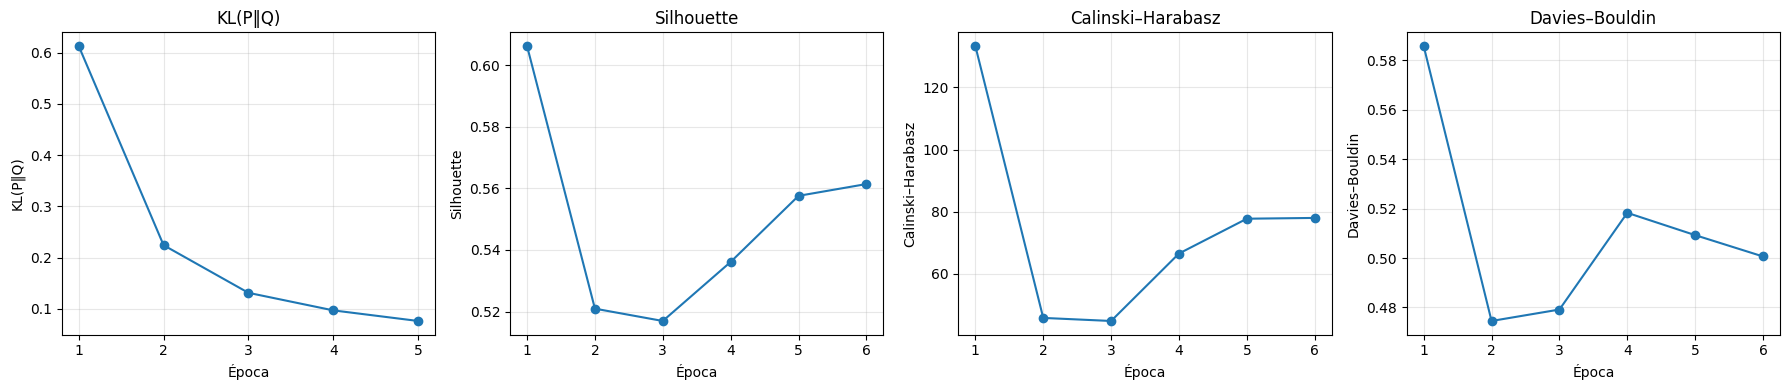

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


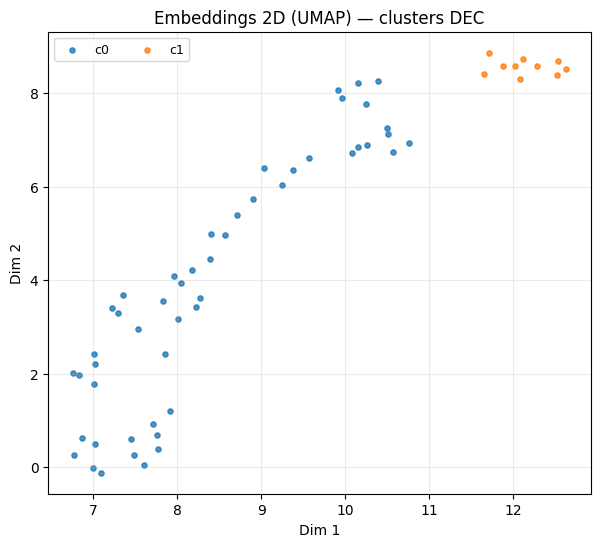

In [ ]:
# Parámetros (ajustar para  esta sección)
SEED               = 80   # Semilla para t-SNE (y UMAP si DETERMINISTIC_UMAP=True)
DETERMINISTIC_UMAP = True  # True = fija semilla (reproducible, más lento, sin paralelismo); False = paralelo, no determinista
RUN_IDEC           = False   # True para ejecutar IDEC; False solo plots/UMAP de DEC
LAMBDA_REC         = 1e-2   # Peso de reconstrucción en IDEC (1e-3 a 5e-2 razonable)
UMAP_N_NEIGHBORS   = 15     # Vecinos para UMAP
UMAP_MIN_DIST      = 0.10   # min_dist para UMAP
HIST_FIGSIZE       = (18, 4)  # Tamaño figura historia (1x4)

# Librerías
import copy
from torch.utils.data import ConcatDataset, Dataset, DataLoader
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# --- Comprobaciones de objetos previos ---
assert 'RESULT_DEC' in globals(), "No se encontró RESULT_DEC. Ejecuta antes la Parte 3 (DEC)."
assert 'ae' in globals(), "No se encontró 'ae' (autoencoder). Ejecuta Parte 1/2."
assert 'cluster_layer' in globals(), "No se encontró 'cluster_layer'. Ejecuta Parte 2."
assert 'ds_train' in globals(), "No se encontró 'ds_train'. Ejecuta Parte 1."
if 'ds_val' not in globals():
    # Dummy vacío si no hubo validación
    class _EmptyDS(torch.utils.data.Dataset):
        def __len__(self): return 0
        def __getitem__(self, i): return None
    ds_val = _EmptyDS()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 1) HISTORIA DEC EN UNA FILA (1x4)
# -----------------------------
hist = RESULT_DEC["history"]
epochs_kl = np.arange(1, len(hist.get("kl", [])) + 1)
epochs_m  = np.arange(1, len(hist.get("silhouette", [])) + 1)

fig, axes = plt.subplots(1, 4, figsize=HIST_FIGSIZE)
axes[0].plot(epochs_kl, hist.get("kl", []), marker='o')
axes[0].set_xlabel("Época"); axes[0].set_ylabel("KL(P‖Q)"); axes[0].set_title("KL(P‖Q)")

axes[1].plot(epochs_m, hist.get("silhouette", []), marker='o')
axes[1].set_xlabel("Época"); axes[1].set_ylabel("Silhouette"); axes[1].set_title("Silhouette")

axes[2].plot(epochs_m, hist.get("calinski_harabasz", []), marker='o')
axes[2].set_xlabel("Época"); axes[2].set_ylabel("Calinski–Harabasz"); axes[2].set_title("Calinski–Harabasz")

axes[3].plot(epochs_m, hist.get("davies_bouldin", []), marker='o')
axes[3].set_xlabel("Época"); axes[3].set_ylabel("Davies–Bouldin"); axes[3].set_title("Davies–Bouldin")

for ax in axes: ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# -----------------------------
# 2) EMBEDDING 2D (UMAP o t-SNE)
# -----------------------------
Z_final = RESULT_DEC["embeddings"]          # (N, L)
y_final = RESULT_DEC["labels_pred"]         # (N,)

def reduce_2d(Z, deterministic_umap=False, seed=2025, n_neighbors=15, min_dist=0.1):
    try:
        import umap
        if deterministic_umap:
            reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=seed)
            # Nota: al fijar random_state, UMAP fuerza n_jobs=1 (más lento, reproducible)
        else:
            reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)  # sin random_state → paralelismo
        Z2 = reducer.fit_transform(Z)
        return Z2, "UMAP"
    except Exception:
        from sklearn.manifold import TSNE
        reducer = TSNE(
            n_components=2,
            perplexity=min(30, max(5, Z.shape[0]//5)),
            learning_rate='auto',
            init='pca',
            random_state=seed
        )
        Z2 = reducer.fit_transform(Z)
        return Z2, "t-SNE"

Z2, method = reduce_2d(Z_final,
                       deterministic_umap=DETERMINISTIC_UMAP,
                       seed=SEED,
                       n_neighbors=UMAP_N_NEIGHBORS,
                       min_dist=UMAP_MIN_DIST)

plt.figure(figsize=(7,6))
for k in sorted(np.unique(y_final)):
    idx = (y_final == k)
    plt.scatter(Z2[idx,0], Z2[idx,1], s=14, alpha=0.8, label=f"c{k}")
plt.title(f"Embeddings 2D ({method}) — clusters DEC")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.legend(loc="best", ncol=2, fontsize=9, frameon=True)
plt.grid(True, alpha=0.25)
plt.show()

# -----------------------------
# 3) IDEC OPCIONAL (DEC + Reconstrucción)
# -----------------------------
class IndexDataset(Dataset):
    def __init__(self, base): self.base = base
    def __len__(self): return len(self.base)
    def __getitem__(self, i):
        x, y = self.base[i]
        return x, y, i  # devolver índice global

if 'ds_val' in globals() and len(ds_val) > 0:
    ds_all = ConcatDataset([ds_train, ds_val])
else:
    ds_all = ds_train

dl_all_ordered = DataLoader(IndexDataset(ds_all), batch_size=64, shuffle=False, drop_last=False)
dl_all_shuffled = DataLoader(IndexDataset(ds_all), batch_size=64, shuffle=True,  drop_last=False)

@torch.no_grad()
def compute_q_all(encoder, cl_layer, dataloader, device):
    encoder.eval(); cl_layer.eval()
    Q_list, Z_list = [], []
    for xb, _, _ in dataloader:
        xb = xb.to(device, non_blocking=True)
        z = encoder(xb); q = cl_layer(z)
        Q_list.append(q.detach().cpu()); Z_list.append(z.detach().cpu())
    Q = torch.cat(Q_list, dim=0); Z = torch.cat(Z_list, dim=0).numpy()
    Q = torch.clamp(Q, 1e-8, 1.0); Q = Q / Q.sum(dim=1, keepdim=True)
    return Q, Z

def target_distribution(Q):
    weight = (Q ** 2) / torch.sum(Q, dim=0, keepdim=True)
    P = weight / torch.sum(weight, dim=1, keepdim=True)
    P = torch.clamp(P, 1e-8, 1.0); P = P / P.sum(dim=1, keepdim=True)
    return P

def cluster_metrics(Z, labels):
    try: sil = silhouette_score(Z, labels)
    except Exception: sil = float('nan')
    try: ch = calinski_harabasz_score(Z, labels)
    except Exception: ch = float('nan')
    try: db = davies_bouldin_score(Z, labels)
    except Exception: db = float('nan')
    return sil, ch, db

def idec_train(ae_model, cl_layer, dl_ordered, dl_shuffled,
               epochs=40, lr=1e-4, wd=0.0, lambda_rec=1e-2,
               update_interval=1, tol=1e-3, device='cpu', seed=2025,
               deterministic_umap=False, n_neighbors=15, min_dist=0.1):
    ae_model = ae_model.to(device); cl_layer = cl_layer.to(device)
    opt = torch.optim.Adam(list(ae_model.parameters()) + list(cl_layer.parameters()), lr=lr, weight_decay=wd)
    recon_loss = torch.nn.L1Loss()
    y_prev = None
    history = {"kl": [], "recon": [], "total": [], "silhouette": [], "calinski_harabasz": [], "davies_bouldin": []}

    for ep in range(1, epochs + 1):
        # Paso E suave
        Q_all, Z_all = compute_q_all(ae_model.encoder, cl_layer, dl_ordered, device)
        P_all = target_distribution(Q_all)
        y_curr = torch.argmax(Q_all, dim=1).numpy()
        sil, ch, db = cluster_metrics(Z_all, y_curr)
        history["silhouette"].append(sil); history["calinski_harabasz"].append(ch); history["davies_bouldin"].append(db)

        if y_prev is not None and len(y_prev) == len(y_curr):
            delta = (y_prev != y_curr).sum() / float(len(y_curr))
            print(f"[IDEC] epoch {ep:02d} - Δasig={delta:.4f} | sil={sil:.4f} ch={ch:.1f} db={db:.4f}")
            if delta < tol and ep > 5:
                print("[IDEC] Convergencia por estabilidad de asignaciones."); break
        else:
            print(f"[IDEC] epoch {ep:02d} - sil={sil:.4f} ch={ch:.1f} db={db:.4f}")
        y_prev = y_curr

        # Paso M
        ae_model.train(); cl_layer.train()
        kl_epoch = rec_epoch = tot_epoch = 0.0; n_batches = 0
        for xb, _, idx in dl_shuffled:
            xb = xb.to(device, non_blocking=True); idx = idx.long()
            z, xr = ae_model(xb); q = cl_layer(z)
            q = torch.clamp(q, 1e-8, 1.0); q = q / q.sum(dim=1, keepdim=True)
            p = P_all[idx].to(device)
            kl = F.kl_div(q.log(), p, reduction="batchmean")
            rec = recon_loss(xr, xb)
            loss = kl + lambda_rec * rec
            opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
            kl_epoch += kl.item(); rec_epoch += rec.item(); tot_epoch += loss.item(); n_batches += 1
        kl_epoch  /= max(1, n_batches); rec_epoch /= max(1, n_batches); tot_epoch /= max(1, n_batches)
        history["kl"].append(kl_epoch); history["recon"].append(rec_epoch); history["total"].append(tot_epoch)
        print(f"       KL={kl_epoch:.5f} | Recon={rec_epoch:.5f} | Total={tot_epoch:.5f}")

    # Resultados finales
    Q_final, Z_final = compute_q_all(ae_model.encoder, cl_layer, dl_ordered, device)
    P_final = target_distribution(Q_final); y_final = torch.argmax(Q_final, dim=1).numpy()
    unique, counts = np.unique(y_final, return_counts=True)
    print(f"\n[IDEC] Clusters finales: {dict(zip(unique.tolist(), counts.tolist()))}")

    # Embedding 2D opcional (para retorno)
    Z2, method = reduce_2d(Z_final,
                           deterministic_umap=deterministic_umap,
                           seed=seed,
                           n_neighbors=n_neighbors,
                           min_dist=min_dist)

    return {"Q": Q_final.numpy(), "P": P_final.numpy(), "labels_pred": y_final,
            "embeddings": Z_final, "embeddings_2d": Z2, "embeddings_2d_method": method,
            "history": history, "centers": cl_layer.cluster_centers.detach().cpu().numpy()}

# Ejecutar IDEC si RUN_IDEC=True
if RUN_IDEC:
    ae_id = copy.deepcopy(ae)  # copia para comparar con DEC
    RESULT_IDEC = idec_train(
        ae_model=ae_id, cl_layer=cluster_layer,
        dl_ordered=dl_all_ordered, dl_shuffled=dl_all_shuffled,
        epochs=40, lr=1e-4, wd=0.0, lambda_rec=LAMBDA_REC,
        update_interval=1, tol=1e-3, device=DEVICE, seed=SEED,
        deterministic_umap=DETERMINISTIC_UMAP, n_neighbors=UMAP_N_NEIGHBORS, min_dist=UMAP_MIN_DIST
    )

    # Plots de historia IDEC (1x3)
    h = RESULT_IDEC["history"]; ep_t = np.arange(1, len(h["total"]) + 1)
    fig, axes = plt.subplots(1, 3, figsize=(14,4))
    axes[0].plot(ep_t, h["total"], marker='o'); axes[0].set_title("Pérdida Total"); axes[0].set_xlabel("Época"); axes[0].set_ylabel("Pérdida")
    axes[1].plot(ep_t, h["kl"],    marker='o'); axes[1].set_title("KL(P‖Q)");     axes[1].set_xlabel("Época"); axes[1].set_ylabel("KL")
    axes[2].plot(ep_t, h["recon"], marker='o'); axes[2].set_title("Reconstrucción"); axes[2].set_xlabel("Época"); axes[2].set_ylabel("L1")
    for ax in axes: ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    # Proyección 2D IDEC (usando los mismos parámetros)
    Z2_id = RESULT_IDEC["embeddings_2d"]; method_id = RESULT_IDEC["embeddings_2d_method"]
    y_id = RESULT_IDEC["labels_pred"]
    plt.figure(figsize=(7,6))
    for k in sorted(np.unique(y_id)):
        idx = (y_id == k)
        plt.scatter(Z2_id[idx,0], Z2_id[idx,1], s=14, alpha=0.8, label=f"c{k}")
    plt.title(f"Embeddings 2D ({method_id}) — clusters IDEC")
    plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
    plt.legend(loc="best", ncol=2, fontsize=9, frameon=True)
    plt.grid(True, alpha=0.25)
    plt.show()


# **2. Evaluación + Inferencia (DEC) con diagnóstico opcional y detección simple de anomalías**

1. Evaluación en el espacio latente: métricas internas (Silhouette, CH, DB).

2. (Opcional) Diagnóstico con etiquetas sintéticas: NMI/ARI y mapeo húngaro para ver qué tan bien se corresponden los clústeres con tus tipos.

3. Inferencia sobre:
  * Escalogramas ya calculados (matrices F×T normalizadas), y
  * Señales crudas (1 s @ 5 kHz): calcula CWT + normaliza → predice.

4. Detección simple de anomalías: distancia al centro en 𝑧 normalizada por el radio (p-percentil) de su clúster; además se reporta confianza (max 𝑞) y entropía de 𝑞.

Embeddings: (60, 64) | K=2
[Internas en Z] Silhouette=0.5614 | CH=78.0 | DB=0.5006
[Con GT] NMI=0.3173 | ARI=0.1263 | Acc(mapeo húngaro)=0.4167
Mapa clúster→clase: {np.int64(0): np.int64(1), np.int64(1): np.int64(0)}  (matriz conf: filas=pred, cols=clase)
Resumen por clúster (conteos): {0: 50, 1: 10}


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


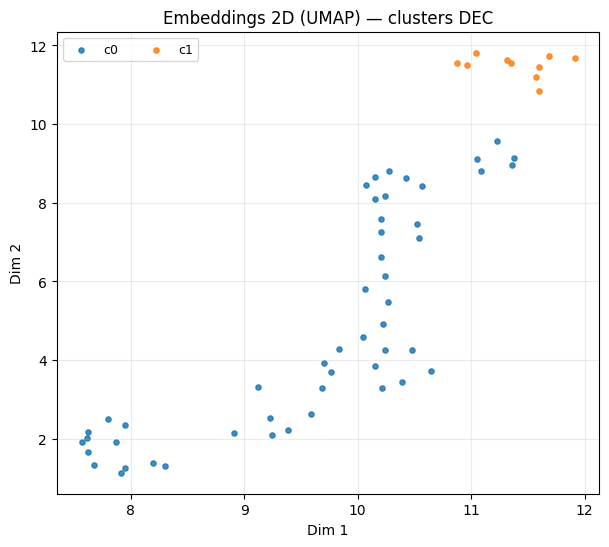

In [ ]:
# Requisitos en memoria (Partes 1–3): ae, cluster_layer, ds_train, ds_val (opcional), dl_all_ordered (opcional).

# -----------------------------
# Parámetros (ajustar aquí)
# -----------------------------
EVAL_WITH_GROUNDTRUTH = True   # True si los datasets llevan 'labels' (sintéticas) y quieres NMI/ARI + mapeo húngaro
RUN_UMAP_2D           = True   # Poner False si se quiere la proyección 2D en esta fase
SEED                  = 2025
ANOMALY_PERCENTILE    = 95.0   # p-percentil por clúster para normalizar distancia (95–99 suele ir bien)
UMAP_N_NEIGHBORS      = 15
UMAP_MIN_DIST         = 0.10
DETERMINISTIC_UMAP    = True  # True: reproducible (más lento); False: paralelo (no determinista)


# -----------------------------
# Imports y utilidades
# -----------------------------
import torch, math
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Asegurar dl_all_ordered si no existe
class IndexDataset(Dataset):
    def __init__(self, base): self.base = base
    def __len__(self): return len(self.base)
    def __getitem__(self, i):
        x, y = self.base[i]
        return x, y, i

if 'ds_val' in globals() and len(ds_val) > 0:
    ds_all = ConcatDataset([ds_train, ds_val])
else:
    ds_all = ds_train

if 'dl_all_ordered' not in globals():
    dl_all_ordered = DataLoader(IndexDataset(ds_all), batch_size=64, shuffle=False, drop_last=False)


# -----------------------------
# 1) Embeddings, Q y predicciones
# -----------------------------
@torch.no_grad()
def get_Z_Q_predictions(encoder, cl_layer, dataloader, device=DEVICE):
    encoder.eval(); cl_layer.eval()
    Z_list, Q_list, yhat_list = [], [], []
    for xb, _, _ in dataloader:
        xb = xb.to(device, non_blocking=True)
        z = encoder(xb)
        q = cl_layer(z)
        q = torch.clamp(q, 1e-8, 1.0)
        q = q / q.sum(dim=1, keepdim=True)
        Z_list.append(z.detach().cpu().numpy())
        Q_list.append(q.detach().cpu().numpy())
        yhat_list.append(q.argmax(dim=1).cpu().numpy())
    Z = np.concatenate(Z_list, axis=0)
    Q = np.concatenate(Q_list, axis=0)
    y_pred = np.concatenate(yhat_list, axis=0)
    return Z, Q, y_pred

Z, Q, y_pred = get_Z_Q_predictions(ae.encoder, cluster_layer, dl_all_ordered, device=DEVICE)
centers = cluster_layer.cluster_centers.detach().cpu().numpy()
K = centers.shape[0]
print(f"Embeddings: {Z.shape} | K={K}")


# -----------------------------
# 2) Métricas internas en Z
# -----------------------------
def cluster_metrics(Z, y):
    def safe(fn, *args):
        try: return fn(*args)
        except Exception: return float('nan')
    sil = safe(silhouette_score, Z, y)
    ch  = safe(calinski_harabasz_score, Z, y)
    db  = safe(davies_bouldin_score, Z, y)
    return sil, ch, db

sil, ch, db = cluster_metrics(Z, y_pred)
print(f"[Internas en Z] Silhouette={sil:.4f} | CH={ch:.1f} | DB={db:.4f}")


# -----------------------------
# 3) Diagnóstico con etiquetas (opcional)
# -----------------------------
if EVAL_WITH_GROUNDTRUTH:
    # Extraer etiquetas 'y_true' desde ds_all (strings) y codificarlas a enteros
    y_true_str = [ds_all[i][1] for i in range(len(ds_all))]
    classes = {s:i for i, s in enumerate(sorted(set(y_true_str)))}
    y_true = np.array([classes[s] for s in y_true_str], dtype=int)

    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)

    # Mapeo húngaro para máxima coincidencia (permuta clústeres predichos a clases)
    C = np.zeros((K, len(classes)), dtype=int)
    for yp, yt in zip(y_pred, y_true):
        if yp < K and yt < C.shape[1]:
            C[yp, yt] += 1
    row_ind, col_ind = linear_sum_assignment(C.max() - C)  # maximizar acierto
    mapping = {row: col for row, col in zip(row_ind, col_ind)}
    acc = C[row_ind, col_ind].sum() / C.sum()

    print(f"[Con GT] NMI={nmi:.4f} | ARI={ari:.4f} | Acc(mapeo húngaro)={acc:.4f}")
    print(f"Mapa clúster→clase: {mapping}  (matriz conf: filas=pred, cols=clase)")


# -----------------------------
# 4) Radios por clúster y scores de anomalía
# -----------------------------
def cluster_radii(Z, y_pred, centers, percentile=95.0):
    # distancia euclídea al centro de su clúster
    dists = np.linalg.norm(Z - centers[y_pred], axis=1)
    radii = np.zeros(centers.shape[0], dtype=float)
    for k in range(centers.shape[0]):
        dk = dists[y_pred == k]
        radii[k] = np.percentile(dk, percentile) if dk.size else 0.0
    return dists, radii

dists, radii = cluster_radii(Z, y_pred, centers, percentile=ANOMALY_PERCENTILE)
d_norm = np.divide(dists, radii[np.clip(y_pred, 0, K-1)], out=np.ones_like(dists), where=radii[np.clip(y_pred,0,K-1)]>1e-9)
conf   = Q.max(axis=1)                         # confianza (máx q)
ent    = -np.sum(Q * np.log(Q + 1e-12), axis=1)# entropía

print("Resumen por clúster (conteos):", {int(k): int((y_pred==k).sum()) for k in np.unique(y_pred)})


# -----------------------------
# 5) Visualización 2D (UMAP/t-SNE) coloreada por clúster
# -----------------------------
def reduce_2d(Z, deterministic_umap=False, seed=SEED, n_neighbors=UMAP_N_NEIGHBORS, min_dist=UMAP_MIN_DIST):
    try:
        import umap
        if deterministic_umap:
            reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=seed)
        else:
            reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
        return reducer.fit_transform(Z), "UMAP"
    except Exception:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, perplexity=min(30, max(5, Z.shape[0]//5)),
                       learning_rate='auto', init='pca', random_state=seed)
        return reducer.fit_transform(Z), "t-SNE"

if RUN_UMAP_2D:
    Z2, method = reduce_2d(Z, DETERMINISTIC_UMAP, SEED)
    plt.figure(figsize=(7,6))
    for k in sorted(np.unique(y_pred)):
        idx = (y_pred == k)
        plt.scatter(Z2[idx,0], Z2[idx,1], s=14, alpha=0.85, label=f"c{k}")
    plt.title(f"Embeddings 2D ({method}) — clusters DEC")
    plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
    plt.legend(loc="best", ncol=2, fontsize=9, frameon=True)
    plt.grid(True, alpha=0.25); plt.show()


# -----------------------------
# 6) Inferencia sobre NUEVOS datos
# -----------------------------
# 6.1. Inferencia desde ESCALOGRAMAS ya normalizados (lista de arrays F×T en [0,1])
import torch.nn as nn

def _resize_to_img(tensor_1xHxW, size):
    # tensor_1xHxW: torch.Tensor (1,H,W)
    return F.interpolate(tensor_1xHxW.unsqueeze(0), size=size, mode='bilinear', align_corners=False).squeeze(0)

@torch.no_grad()
def predict_from_scalograms(scalograms_list, img_size=(224,224), device=DEVICE):
    ae.encoder.eval(); cluster_layer.eval()
    preds = []
    for S in scalograms_list:
        S = np.asarray(S, dtype=np.float32)
        S = np.clip(S, 0.0, 1.0)
        x = torch.from_numpy(S)[None, ...]   # (1,F,T)
        x = _resize_to_img(x, img_size).unsqueeze(0).to(device)  # (1,1,H,W)
        z = ae.encoder(x)
        q = cluster_layer(z)
        q = torch.clamp(q, 1e-8, 1.0)
        q = q / q.sum(dim=1, keepdim=True)
        yhat = int(q.argmax(dim=1).item())
        q_np = q.squeeze(0).cpu().numpy()
        # dist y scores
        c = centers[yhat]
        d = float(np.linalg.norm(z.squeeze(0).detach().cpu().numpy() - c))
        r = float(radii[yhat] if yhat < len(radii) else 1.0)
        preds.append({
            "y_pred": yhat,
            "q": q_np,
            "conf": float(q_np.max()),
            "entropy": float(-(q_np * np.log(q_np + 1e-12)).sum()),
            "dist": d,
            "dist_norm": float(d / (r + 1e-9)),
            "anomaly": bool(d > r)  # fuera del p-percentil del clúster
        })
    return preds

# 6.2. Inferencia desde SEÑALES crudas (1 s @ fs)
#     Incluye CWT + normalización (reusa PyWavelets si está instalado).
def _compute_cwt(signal, fs):
    try:
        import pywt
        freqs = np.linspace(20, 1200, 256)
        fc = pywt.central_frequency('morl')
        scales = fc * fs / freqs
        coef, _ = pywt.cwt(signal.astype(np.float32), scales, 'morl', sampling_period=1.0/fs)
        power = np.abs(coef) ** 2
    except Exception:
        from scipy.signal import cwt, ricker
        widths = np.linspace(1, 250, 250)
        coef = cwt(signal.astype(np.float32), ricker, widths)
        power = np.abs(coef) ** 2
    power = np.log1p(power)
    # normalizar a [0,1]
    pmin, pmax = power.min(), power.max()
    power = (power - pmin) / (pmax - pmin + 1e-12)
    return power.astype(np.float32)

@torch.no_grad()
def predict_from_raw_signals(signals_list, fs=5000.0, img_size=(224,224), device=DEVICE):
    scalos = [_compute_cwt(sig, fs) for sig in signals_list]
    return predict_from_scalograms(scalos, img_size, device)

# -----------------------------
# 7) Ejemplos de uso
# -----------------------------
# # (A) Inferir sobre los mismos escalogramas ya usados:
# preds = predict_from_scalograms([ds_all[i][0].squeeze(0).numpy() for i in range(len(ds_all))], img_size=IMG_SIZE)
# print("Ejemplo de predicción 0:", preds[0])

# # (B) Inferir sobre señales crudas nuevas (lista de arrays 1D):
# # new_preds = predict_from_raw_signals([mi_senal_1s, mi_senal_1s_2], fs=5000.0, img_size=IMG_SIZE)
# # print(new_preds[0])
